In [1]:
import time 
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

import optuna
from xgboost import XGBClassifier, XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

d:\Skripsi\Location Prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = 'data_preprocessed.csv'  
df = pd.read_csv(path)
print(df.shape)

(1984, 12)


In [3]:
df.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric
1321,2024-10-23 07:24:12.080672200+00:00,41,3,DTE Staff,2,1,2454,1037,-200.0,-64.0,1,07:24:12.080672
76,2024-10-17 09:00:17.716274900+00:00,2,18,DTE Student,4,11,300,1567,-63.0,-200.0,0,09:00:17.716274
530,2024-10-17 10:31:15.907614500+00:00,30,6,DTE Staff,3,11,989,1202,-42.0,-200.0,1,10:31:15.907614
629,2024-10-17 10:43:18.522535900+00:00,37,11,DTE Student,4,11,1908,1037,-53.0,-200.0,1,10:43:18.522535
1503,2024-10-23 07:47:25.337724200+00:00,39,10,DTE Staff,3,11,2224,1037,-61.0,-200.0,1,07:47:25.337724


In [4]:
# Drop columns
df = df.drop(columns=['time', 'time_numeric', 'ssid'])

In [5]:
def get_obstacle_loss(row):
    """
    Function to determine obstacle loss based on the reference point and connected access point (BSSID).
    """
    reference_point = row['reference_point']
    bssid = row['bssid']
    
    if bssid == 3:  # digilab AP1
        if 1 <= reference_point <= 10:
            return 10
        elif (11 <= reference_point <= 20) or (reference_point == 49):
            return 5
        elif 29 <= reference_point <= 42:
            return 0

    elif bssid == 4:  # digilab AP2
        if 1 <= reference_point <= 10:
            return 10
        elif (11 <= reference_point <= 20) or (reference_point == 49):
            return 5
        elif 29 <= reference_point <= 42:
            return 0

    elif bssid == 1:  # dosen AP1
        if 29 <= reference_point <= 42:
            return 20
        elif (11 <= reference_point <= 20) or (reference_point == 49):
            return 25
        elif 1 <= reference_point <= 10:
            return 28

    elif bssid == 2:  # dosen AP2
        if 29 <= reference_point <= 42:
            return 20
        elif (11 <= reference_point <= 20) or (reference_point == 49):
            return 25
        elif 1 <= reference_point <= 10:
            return 28

    # If none of the above conditions are met, return a default value or NaN
    return None

# Apply the function to the DataFrame and create a new 'obstacle_loss' column
df['obstacle_loss'] = df.apply(get_obstacle_loss, axis=1)

df.sample(5)

,reference_point,iteration,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,obstacle_loss
1535,39,18,1,1,2224,1037,-200.0,-70.0,1,20
1118,38,11,2,1,1908,1202,-200.0,-81.0,1,20
727,11,19,4,11,759,1368,-62.0,-200.0,0,5
1969,31,17,3,11,1219,1037,-43.0,-200.0,1,0
1801,34,15,3,11,1449,1202,-48.0,-200.0,1,0


In [6]:
# Define the mapping dictionary for converting numeric BSSID back to normal
numeric_to_bssid = {
    1: '70:a7:41:dc:8e:55',  # AP Dosen (DTE Staff)
    2: '72:a7:41:9c:8e:55',  # AP Dosen (DTE Student)
    3: '70:a7:41:dc:77:cd',  # AP Digilab (DTE Staff)
    4: '72:a7:41:9c:77:cd'   # AP Digilab (DTE Student)
}

# Replace numeric BSSID identifiers in the 'bssid' column with their original format
df['bssid'] = df['bssid'].map(numeric_to_bssid)

# Print the updated DataFrame to check the conversion
df.sample(5)

,reference_point,iteration,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,obstacle_loss
1666,33,1,70:a7:41:dc:77:cd,11,1449,1037,-48.0,-200.0,1,0
1827,32,1,70:a7:41:dc:8e:55,1,1219,1202,-200.0,-94.0,1,20
1212,36,15,72:a7:41:9c:8e:55,1,1678,1202,-200.0,-86.0,1,20
1235,42,1,70:a7:41:dc:8e:55,1,2454,1202,-200.0,-70.0,1,20
1377,41,18,70:a7:41:dc:77:cd,11,2454,1037,-62.0,-200.0,1,0


In [7]:
ap_coordinates = {
    '70:a7:41:dc:77:cd': (870, 1122),  # AP Digilab (DTE Staff)
    '72:a7:41:9c:77:cd': (870, 1122),  # AP Digilab (DTE Student)
    '70:a7:41:dc:8e:55': (2314, 468),  # AP Dosen (DTE Staff)
    '72:a7:41:9c:8e:55': (2314, 468),  # AP Dosen (DTE Student)
}

# Map each row to the corresponding AP coordinates
def get_ap_coordinates(bssid):
    return ap_coordinates.get(bssid, (np.nan, np.nan))  # Default to NaN if BSSID not found

df['ap_x'], df['ap_y'] = zip(*df['bssid'].map(get_ap_coordinates))

# Step 2: Calculate the distance to the corresponding AP
df['distance'] = np.sqrt((df['xr'] - df['ap_x'])**2 + (df['yr'] - df['ap_y'])**2)

# Display the updated DataFrame
df.sample(5)

,reference_point,iteration,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,obstacle_loss,ap_x,ap_y,distance
513,30,2,70:a7:41:dc:77:cd,11,989,1202,-41.0,-200.0,1,0,870,1122,143.391074
528,30,5,72:a7:41:9c:8e:55,1,989,1202,-200.0,-91.0,1,20,2314,468,1514.721427
1443,40,14,70:a7:41:dc:8e:55,1,2224,1202,-200.0,-83.0,1,20,2314,468,739.497126
1148,38,19,70:a7:41:dc:77:cd,11,1908,1202,-53.0,-200.0,1,0,870,1122,1041.078287
1914,31,3,72:a7:41:9c:8e:55,1,1219,1037,-200.0,-81.0,1,20,2314,468,1234.012156


In [8]:
# Define the mapping dictionary for converting numeric BSSID back to normal
bssid_to_numeric = {
    '70:a7:41:dc:8e:55':1,  # AP Dosen (DTE Staff)
    '72:a7:41:9c:8e:55':2,  # AP Dosen (DTE Student)
    '70:a7:41:dc:77:cd':3,  # AP Digilab (DTE Staff)
    '72:a7:41:9c:77:cd':4   # AP Digilab (DTE Student)
}

# Replace numeric BSSID identifiers in the 'bssid' column with their original format
df['bssid'] = df['bssid'].map(bssid_to_numeric)

# Print the updated DataFrame to check the conversion
df.sample(5)

,reference_point,iteration,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,obstacle_loss,ap_x,ap_y,distance
646,37,18,4,11,1908,1037,-52.0,-200.0,1,0,870,1122,1041.474436
477,29,12,1,1,989,1037,-200.0,-90.0,1,20,2314,468,1442.007628
780,13,3,3,11,759,1749,-77.0,-200.0,0,5,870,1122,636.749558
1399,40,3,2,1,2224,1202,-200.0,-87.0,1,20,2314,468,739.497126
431,29,1,3,11,989,1037,-43.0,-200.0,1,0,870,1122,146.239530


                   reference_point  iteration     bssid   channel        xr  \
reference_point           1.000000   0.005019 -0.333691 -0.381249  0.908182   
iteration                 0.005019   1.000000 -0.012741 -0.009956  0.004220   
bssid                    -0.333691  -0.012741  1.000000  0.878881 -0.311043   
channel                  -0.381249  -0.009956  0.878881  1.000000 -0.355584   
xr                        0.908182   0.004220 -0.311043 -0.355584  1.000000   
yr                       -0.714255   0.002322  0.370544  0.420721 -0.675474   
rssi_ap_digilab          -0.334552  -0.010661  0.871277  0.991744 -0.325948   
rssi_ap_dosen             0.401257   0.009336 -0.874879 -0.995611  0.392163   
relative_position         0.928369  -0.001582 -0.385365 -0.439201  0.790541   
obstacle_loss            -0.016268   0.007089 -0.790201 -0.898555 -0.001155   
ap_x                      0.381249   0.009956 -0.878881 -1.000000  0.355584   
ap_y                     -0.381249  -0.009956  0.878

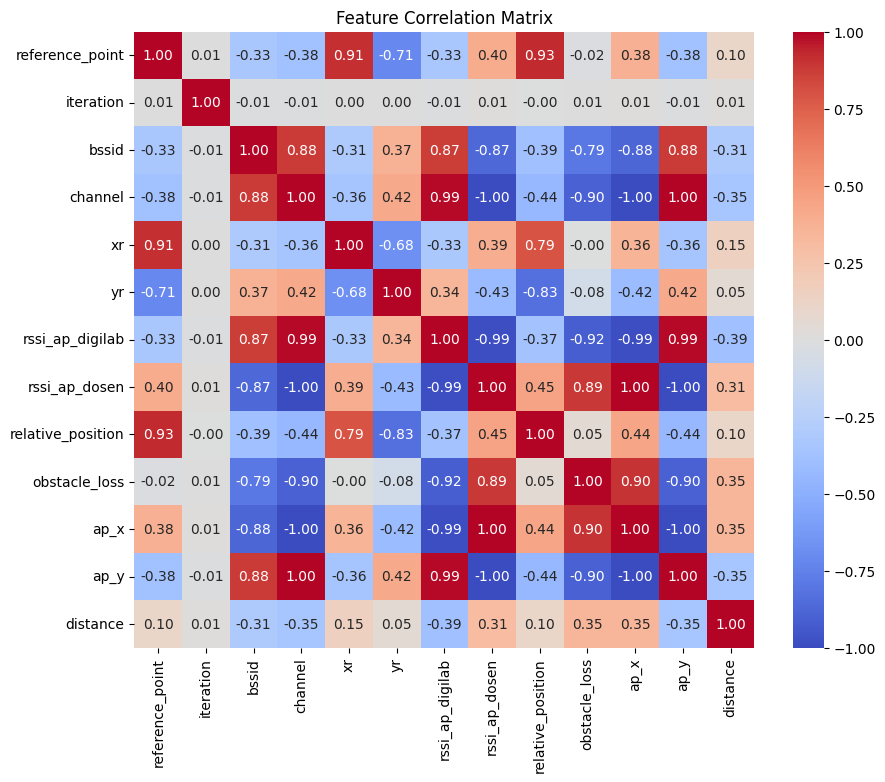

In [9]:
import pandas as pd
import numpy as np

# Compute correlation matrix
correlation_matrix = df.corr(method='pearson')  # Use 'spearman' for rank correlation

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [10]:
# Save the dataframe
df.to_csv('test.csv', index=False)
print(f"Data saved to {'test.csv'}")

Data saved to test.csv


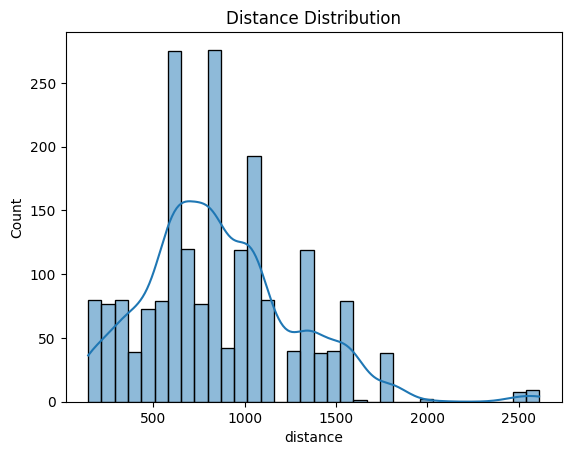

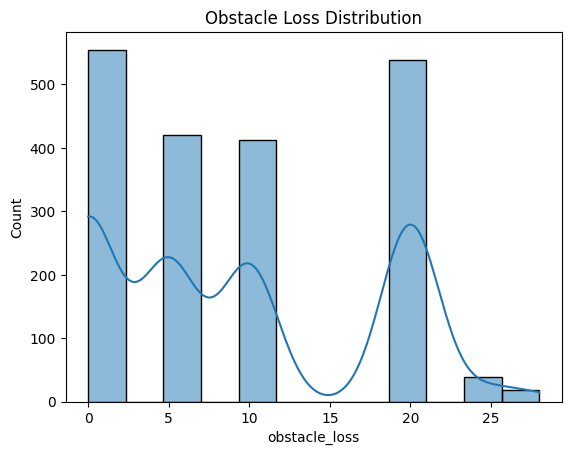

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions
sns.histplot(df['distance'], kde=True)
plt.title('Distance Distribution')
plt.show()

sns.histplot(df['obstacle_loss'], kde=True)
plt.title('Obstacle Loss Distribution')
plt.show()


In [12]:
# Function to compute d0 and RSSI_d0
def compute_reference_values():
    return {
        'd0': 1003.58,
        'RSSI_d0': -64
    }

# Compute and display the reference values for AP Dosen
reference_values = compute_reference_values()
print("Reference values:")
print(reference_values)


Reference values:
{'d0': 1003.58, 'RSSI_d0': -64}


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the pathloss model with obstacle loss
def compute_rssi_with_obstacle(RSSI_d0, d0, n, distance, obstacle_loss):
    """
    Compute the RSSI using the pathloss model and obstacle loss.
    """
    rssi = RSSI_d0 - 9.8 * n * np.log10(distance / d0) - obstacle_loss
    return rssi

RSSI_d0_digilab = -75  # RSSI at reference distance (d0) for AP Dosen
d0_digilab = 1003.58  # Reference distance for AP Dosen
RSSI_d0_dosen = -83
d0_dosen = 853.38
n_dosen = 3  # Path loss exponent for AP Dosen
n_digilab = 2 # Path loss exponent for AP Digilab

# Calculate predicted RSSI for each access point
df['predicted_rssi_ap_dosen'] = compute_rssi_with_obstacle(RSSI_d0_dosen, d0_dosen, n_dosen, df['distance'], df['obstacle_loss'])
df['predicted_rssi_ap_digilab'] = compute_rssi_with_obstacle(RSSI_d0_digilab, d0_digilab, n_digilab, df['distance'], df['obstacle_loss'])

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate error metrics for AP Dosen
mae_dosen = mean_absolute_error(df['rssi_ap_dosen'], df['predicted_rssi_ap_dosen'])
mse_dosen = mean_squared_error(df['rssi_ap_dosen'], df['predicted_rssi_ap_dosen'])
rmse_dosen = np.sqrt(mse_dosen)
r2_dosen = r2_score(df['rssi_ap_dosen'], df['predicted_rssi_ap_dosen'])

# Calculate error metrics for AP Digilab
mae_digilab = mean_absolute_error(df['rssi_ap_digilab'], df['predicted_rssi_ap_digilab'])
mse_digilab = mean_squared_error(df['rssi_ap_digilab'], df['predicted_rssi_ap_digilab'])
rmse_digilab = np.sqrt(mse_digilab)
r2_digilab = r2_score(df['rssi_ap_digilab'], df['predicted_rssi_ap_digilab'])

# Print the error metrics for AP Dosen and AP Digilab
print(f"AP Dosen - MAE: {mae_dosen:.2f}, MSE: {mse_dosen:.2f}, RMSE: {rmse_dosen:.2f}, R²: {r2_dosen:.2f}")
print(f"AP Digilab - MAE: {mae_digilab:.2f}, MSE: {mse_digilab:.2f}, RMSE: {rmse_digilab:.2f}, R²: {r2_digilab:.2f}")

AP Dosen - MAE: 87.46, MSE: 9563.45, RMSE: 97.79, R²: -2.34
AP Digilab - MAE: 42.37, MSE: 3488.55, RMSE: 59.06, R²: 0.16


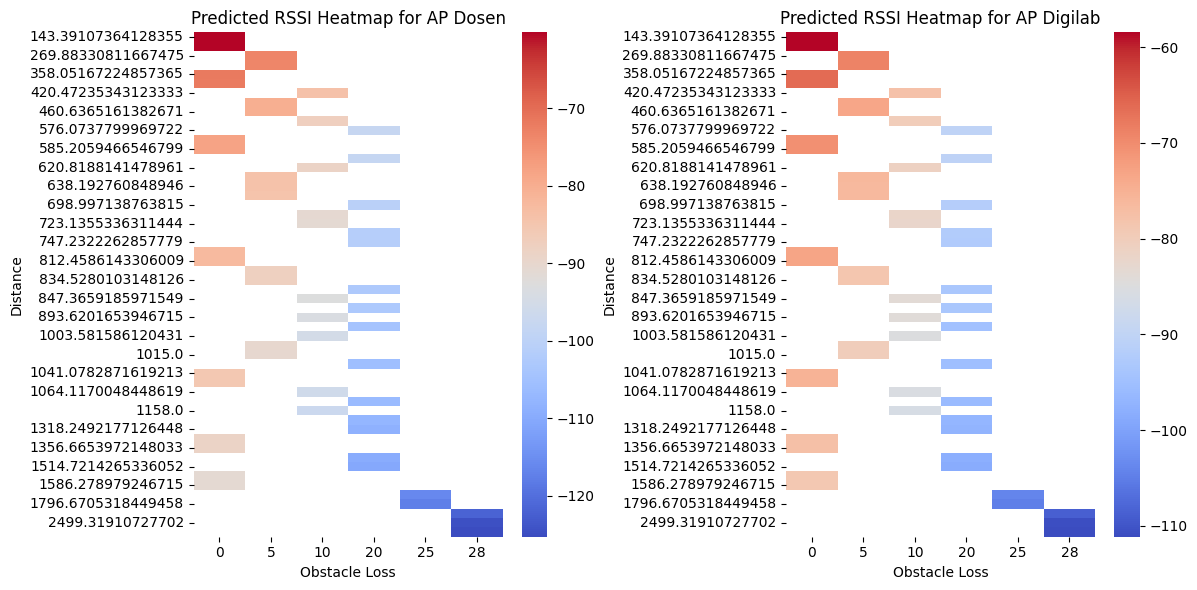

In [15]:
# Create a heatmap for visualization
plt.figure(figsize=(12, 6))

# Combine actual and predicted RSSI values for visualization
heatmap_data_dosen = df.pivot_table(values='predicted_rssi_ap_dosen', index='distance', columns='obstacle_loss')
heatmap_data_digilab = df.pivot_table(values='predicted_rssi_ap_digilab', index='distance', columns='obstacle_loss')

plt.subplot(1, 2, 1)
sns.heatmap(heatmap_data_dosen, cmap='coolwarm', annot=False)
plt.title('Predicted RSSI Heatmap for AP Dosen')
plt.xlabel('Obstacle Loss')
plt.ylabel('Distance')

plt.subplot(1, 2, 2)
sns.heatmap(heatmap_data_digilab, cmap='coolwarm', annot=False)
plt.title('Predicted RSSI Heatmap for AP Digilab')
plt.xlabel('Obstacle Loss')
plt.ylabel('Distance')

plt.tight_layout()
plt.show()